# NC EA Public Middle Schools Dataset Expanded  Feb 2018

## Create Consolidated School Datasets for Machine Learning

In [1]:
#import required Libraries
import pandas as pd
import numpy as np

#Get school level data
url="https://raw.githubusercontent.com/jakemdrew/EducationDataNC/master/Raw%20Datasets/All_Data_By_School_Final.csv"
schData=pd.read_csv(url, low_memory=False, dtype={'unit_code': object})

#Get school level test scores data 
url="https://raw.githubusercontent.com/jakemdrew/EducationDataNC/master/Raw%20Datasets/1516_Test_Scores.csv"
testScores=pd.read_csv(url, low_memory=False, dtype={'unit_code': object})

#Get school level racial compositions data
url="https://raw.githubusercontent.com/jakemdrew/EducationDataNC/master/Raw%20Datasets/" + \
     "Ec_Pupils_Expanded%20(2017%20Race%20Compositions%20by%20School).csv"
raceComps=pd.read_csv(url, low_memory=False, dtype={'unit_code': object, 'LEA': object})

#Convert our primary key to the proper data type before joining. 
raceComps.unit_code = raceComps.unit_code.astype('object')

#Review dataset contents before merging
print('****************School Data*********************************')
schData.info(verbose=False)
print('****************Test Scores*********************************')
testScores.info(verbose=False)
print('****************Racial Compostions**************************')
raceComps.info(verbose=False)


#Merge schoolData and testScores into a single file using school / unit code
schoolData = schData.merge(testScores, on='unit_code', how='left', suffixes=('_schoolData', '_testScores'))

#Review dataset contents after merging
print('****************After testScores Merge**********************')
schoolData.info(verbose=False)

#Merge schoolData and raceComps into a single file using school / unit code
schoolData = schoolData.merge(raceComps, on='unit_code', how='left', suffixes=('', '_Drop'))
#Remove any duplicate columns from racial compostion data file
dropCols = [x for x in schoolData.columns if x.endswith('_Drop')]
schoolData = schoolData.drop(dropCols, axis=1)

#Review dataset contents after merging
print('****************After raceComps Merge***********************')
schoolData.info(verbose=False)

****************School Data*********************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2579 entries, 0 to 2578
Columns: 293 entries, Year to State_Prin_Exp_Pct_10+_Years
dtypes: float64(255), int64(17), object(21)
memory usage: 5.8+ MB
****************Test Scores*********************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2669 entries, 0 to 2668
Columns: 73 entries, District Name to Passing_Math_III
dtypes: float64(69), object(4)
memory usage: 1.5+ MB
****************Racial Compostions**************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2446 entries, 0 to 2445
Columns: 30 entries, Year to Majority_Minority
dtypes: float64(1), int64(25), object(4)
memory usage: 573.4+ KB
****************After testScores Merge**********************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2579 entries, 0 to 2578
Columns: 365 entries, Year to Passing_Math_III
dtypes: float64(324), int64(17), object(24)
memory usage: 7.2+ MB
**

In [2]:
# Map flag fields into bool or categorial  
schoolData['title1_type_flg'] = schoolData['title1_type_flg'].map({-1:True, 0:False})
schoolData['clp_ind_flg'] = schoolData['clp_ind_flg'].map({-1:True, 0:False})
schoolData['focus_clp_flg'] = schoolData['focus_clp_flg'].map({-1:True, 0:False})
schoolData['summer_program_flg'] = schoolData['summer_program_flg'].map({-1:True, 0:False})
schoolData['asm_no_spg_flg'] = schoolData['asm_no_spg_flg'].map({-1:True, 0:False})
schoolData['no_data_spg_flg'] = schoolData['no_data_spg_flg'].map({-1:True, 0:False})
schoolData['stem_flg'] = schoolData['stem_flg'].map({-1:True, 0:False})
schoolData['esea_status'] = schoolData['esea_status'].map({'P':'Esea_Pass', 'F':'Esea_Fail', np.nan:'Non_Esea'})
schoolData['Grad_project_status'] = schoolData['Grad_project_status'].map({'Y':True, 'N':False, np.nan:False})

In [3]:
#Save the indexs for records with a district missing
missingLEAs = schoolData[schoolData['LEA'].isna() == True].index

#Update the district to be the first 2 or 3 digits of the unit_code
schoolData.loc[schoolData['LEA'].isna() == True, 'LEA'] = schoolData['unit_code'].transform(lambda x: str(x[:-3]))

#Check that our update worked as expected
#schoolData.loc[missingLEAs][['LEA','unit_code']]

**We use averages at the district level to impute missing race composition values.**

In [4]:
raceCompositionFields = [ 'Indian Male','Indian Female','Asian Male','Asian Female'
                         ,'Hispanic Male','Hispanic Female','Black Male','Black Female'
                         ,'White Male','White Female','Pacific Island Male','Pacific Island Female'
                         ,'Two or  More Male','Two or  More Female','Total','White','Black','Hispanic'
                         ,'Indian','Asian','Pacific Island','Two or More','White_Pct','Majority_Minority']

#Save the indexs for records with race compisitions missing
missingRace = schoolData[schoolData[raceCompositionFields].isna() == True].index

#Update missing race values with the district average when avaiable 
schoolData[raceCompositionFields] = schoolData.groupby('LEA')[raceCompositionFields].transform(
                                          lambda x: x.fillna(x.mean()))

#Check that our update worked as expected
#schoolData.loc[missingRace][schoolData['Indian Male'].isna()][['LEA','Indian Male']]

## Apply Filter to Review Only Middle Schools

**Code in the following section could be replaced to look at any other subset of Public Schools in North Carolina.  All remaining data cleanup steps may still be performed after that. Here is the criteria applied for middle schoools:**
* **Category Codes**
    * M - School has middle schools grades (6-8)
    * T - School has middle and high school grades
    * A - School has elementary, middle, and high school grades
    * I - School has elementary and middle school grades
* **School Types**
    * The school type code must be 'Public'. Charter and non traditional schools have different / less data available.
    * The school type must be 'Regular School'.
    * The total number of students (student_num) must be > 0.
    
    
**Any other filter could be applied here to look at other public school types for machine learning (Elementary, Middle, Hospital, Middle etc).** 
    

In [5]:
schoolData = schoolData [((schoolData.category_cd == 'M') | 
                          (schoolData.category_cd == 'T') | 
                          (schoolData.category_cd == 'A') |
                          (schoolData.category_cd == 'I')) &
                          (schoolData.student_num > 0) & 
                          (schoolData.type_cd_txt == 'Public') & 
                          (schoolData.school_type_txt == 'Regular School')
                         ]

schoolData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535 entries, 5 to 2417
Columns: 393 entries, Year to Majority_Minority
dtypes: bool(8), float64(349), int64(10), object(26)
memory usage: 1.6+ MB


## Prepare Consolidated Dataset for Machine Learning

**Here we perform operations on the entire dataset to remove fields that could cause problems during machine learning.  Here are the operations performed:**
* Use domain knowledge to remove fields that are not useful for predicting graduation rates. 
* Remove any columns that have the same value in every single row.
* Remove any columns that have a unique value in every single row (all values are different).
* Remove empty columns (all values are NA or NULL).

**See the following link for great details on dataset pre-processing for machine learning:**
* The sklearn.preprocessing library contains tools for preprocessing your data.
* This includes scaling, non-linear transformation, normalization, one hot encoding, binarization, imputation, polynomial features, and custom data transformer functions.   
* http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing

In [6]:
#Remove fields not needed for machine learning
excludeFields = ['unit_code', 'Year', 'street_ad','scity_ad'
                 ,'state_ad','szip_ad','District Name','School Name','SBE District'
                 ,'grades_BYOD','grades_1_to_1_access'
                #raceComp fields to drop
                 ,'LEA','School','___School Name___','____LEA Name____'
                ]

schoolData = schoolData.drop(excludeFields,axis=1)

#Review dataset contents after drops
schoolData.info()
print('Columns Deleted: ', len(excludeFields))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535 entries, 5 to 2417
Columns: 378 entries, type_cd_txt to Majority_Minority
dtypes: bool(8), float64(348), int64(8), object(14)
memory usage: 1.5+ MB
('Columns Deleted: ', 15)


In [7]:
#Remove any fields that have the same value in all rows
UniqueValueCounts = schoolData.apply(pd.Series.nunique)
SingleValueCols = UniqueValueCounts[UniqueValueCounts == 1].index
schoolData = schoolData.drop(SingleValueCols, axis=1)

#Review dataset contents after drops
schoolData.info()
print('Columns Deleted: ', len(SingleValueCols))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535 entries, 5 to 2417
Columns: 305 entries, category_cd to Majority_Minority
dtypes: bool(5), float64(287), int64(3), object(10)
memory usage: 1.2+ MB
('Columns Deleted: ', 73)


In [8]:
#Remove any fields that have unique values in every rows
schoolDataRecordCt = schoolData.shape[0]
UniqueValueCounts = schoolData.apply(pd.Series.nunique)
AllUniqueValueCols = UniqueValueCounts[UniqueValueCounts == schoolDataRecordCt].index
schoolData = schoolData.drop(AllUniqueValueCols, axis=1)

#Review dataset contents after drops
schoolData.info()
print('Columns Deleted: ', len(AllUniqueValueCols))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535 entries, 5 to 2417
Columns: 305 entries, category_cd to Majority_Minority
dtypes: bool(5), float64(287), int64(3), object(10)
memory usage: 1.2+ MB
('Columns Deleted: ', 0)


In [9]:
#Remove any empty fields (null values in every row)
schoolDataRecordCt = schoolData.shape[0]
NullValueCounts = schoolData.isnull().sum()
NullValueCols = NullValueCounts[NullValueCounts == schoolDataRecordCt].index
schoolData = schoolData.drop(NullValueCols, axis=1)

#Review dataset contents after empty field drops
schoolData.info()
print('Columns Deleted: ', len(NullValueCols))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535 entries, 5 to 2417
Columns: 267 entries, category_cd to Majority_Minority
dtypes: bool(5), float64(249), int64(3), object(10)
memory usage: 1.1+ MB
('Columns Deleted: ', 38)


## Handle Missing Values for Continuous Data
* Here we eliminate any numeric columns with more than 65% missing values.  
* Then we impute all remaining missing values with 0.  
* It seems in most cases that schools are not simply not reporting values when they are zero.  However, mean imputation or some other strategy might be considered.   

In [10]:
#Isolate continuous and categorical data types
#These are indexers into the schoolData dataframe and may be used similar to the schoolData dataframe 
sD_boolean = schoolData.loc[:, (schoolData.dtypes == bool) ]
sD_nominal = schoolData.loc[:, (schoolData.dtypes == object)]
sD_continuous = schoolData.loc[:, (schoolData.dtypes != bool) & (schoolData.dtypes != object)]
print "Boolean Columns: ", sD_boolean.shape[1]
print "Nominal Columns: ", sD_nominal.shape[1]
print "Continuous Columns: ", sD_continuous.shape[1]
print "Columns Accounted for: ", sD_nominal.shape[1] + sD_continuous.shape[1] + sD_boolean.shape[1]

Boolean Columns:  5
Nominal Columns:  10
Continuous Columns:  252
Columns Accounted for:  267


In [11]:
#Eliminate continuous columns with more than missingThreshold percentage of missing values
missingThreshold = 0.65
schoolDataRecordCt = sD_continuous.shape[0]
missingValueLimit = schoolDataRecordCt * missingThreshold
NullValueCounts = sD_continuous.isnull().sum()
NullValueCols = NullValueCounts[NullValueCounts >= missingValueLimit].index
schoolData = schoolData.drop(NullValueCols, axis=1)

#Review dataset contents after empty field drops
schoolData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535 entries, 5 to 2417
Columns: 183 entries, category_cd to Majority_Minority
dtypes: bool(5), float64(165), int64(3), object(10)
memory usage: 750.8+ KB


In [12]:
#Isolate categorical variables
sD_nominal = schoolData.loc[:, (schoolData.dtypes == object)]
#one hot encode categorical variables
schoolData = pd.get_dummies(data=schoolData, 
                       columns=sD_nominal, drop_first=True)

#Review dataset contents after empty field drops
schoolData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535 entries, 5 to 2417
Columns: 197 entries, title1_type_flg to 1_to_1_access_Yes
dtypes: bool(5), float64(165), int64(3), uint8(24)
memory usage: 721.5 KB


In [13]:
#Replace all remaining NaN with 0
schoolData = schoolData.fillna(0)

#Check for Missing values again 
missing_values = schoolData.isnull().sum().reset_index()
missing_values.columns = ['Variable Name', 'Number Missing Values']
missing_values = missing_values[missing_values['Number Missing Values'] > 0] 
missing_values

,Variable Name,Number Missing Values


## Identify and Remove Highly Correlated Features
* Find and remove any columns / features that are > 95% correlated
* https://stackoverflow.com/questions/39409866/correlation-heatmap
* https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
* https://codeyarns.com/2015/04/20/how-to-change-font-size-in-seaborn/

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# calculate the correlation matrix
corr_matrix  = schoolData.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# plot the heatmap
fig, ax = plt.subplots(figsize=(180,360)) 
sns.set(font_scale=8)
sns.heatmap(upper[to_drop] , linewidths=.15, ax=ax)

In [15]:
#Restore fontscale back to normal after heatmap
sns.set(font_scale=1)

#Print a list of the columns with correlations > .95
print("Columns to delete with greater than .95 correlation: ",  len(to_drop))
print("*****************************************")
to_drop

('Columns to delete with greater than .95 correlation: ', 69)
*****************************************


['Avg_Dist_Size_EnglishII',
 'Avg_Dist_Size_MathI',
 'Overall Achievement Score',
 'Read Score',
 'Math Score',
 'st_short_susp_per_c_num',
 'lea_avg_age_media_collection',
 'class_teach_num',
 'lea_class_teach_num',
 'lea_lateral_teach_pct',
 'lea_not_highqual_class_all_pct',
 'st_class_teach_num',
 'st_nbpts_num',
 'st_1yr_tchr_trnovr_pct',
 'st_emer_prov_teach_pct',
 'st_lateral_teach_pct',
 'st_highqual_class_pct',
 'Tch_Exp_Pct_0_3_Years',
 'Tch_Exp_Pct_4_10_Years',
 'Tch_Exp_Pct_10+_Years',
 'Dist_Tch_Exp_Pct_0_3_Years',
 'Dist_Tch_Exp_Pct_4_10_Years',
 'Dist_Tch_Exp_Pct_10+_Years',
 'State_Tch_Exp_Pct_0_3_Years',
 'State_Tch_Exp_Pct_4_10_Years',
 'State_Tch_Exp_Pct_10+_Years',
 'All_EOC_Subjects_GLP',
 'All_EOG_EOC_Subjects_CACR',
 'All_EOG_EOC_Subjects_GLP',
 'All_EOG_Subjects_CACR',
 'All_EOG_Subjects_GLP',
 'EOC_Math_I_CACR',
 'EOC_Math_I_GLP',
 'EOG_Gr6_GLP',
 'EOG_Gr7_GLP',
 'EOG_Gr8_GLP',
 'EOG_Math_Gr3-8_CACR',
 'EOG_Math_Gr3-8_GLP',
 'EOG_Math_Gr6_CACR',
 'EOG_Math_Gr6_G

In [16]:
#Check columns before drop 
schoolData.info()

# Drop the highly correlated features from our training data 
schoolData = schoolData.drop(to_drop, axis=1)

#Check columns after drop 
print('*********************************************')
schoolData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535 entries, 5 to 2417
Columns: 197 entries, title1_type_flg to 1_to_1_access_Yes
dtypes: bool(5), float64(165), int64(3), uint8(24)
memory usage: 721.5 KB
*********************************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 535 entries, 5 to 2417
Columns: 128 entries, title1_type_flg to 1_to_1_access_Yes
dtypes: bool(5), float64(100), int64(1), uint8(22)
memory usage: 440.4 KB


In [44]:
#Write the final dataset to a .csv file for later use!
file_path = "D:/BenepactLLC/Belk/NC_Report_Card_Data/February 2018 Report/Datasets/MiddleSchoolsML_02_2018_Expanded.csv"
schoolData.to_csv(file_path, sep=',', index=False)

('Total categorical columns: ', 27)


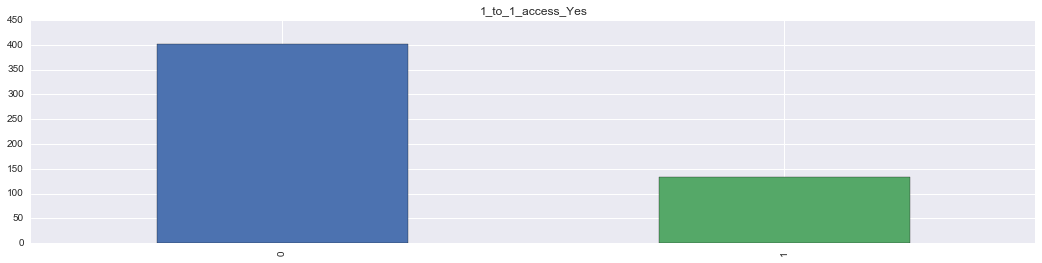

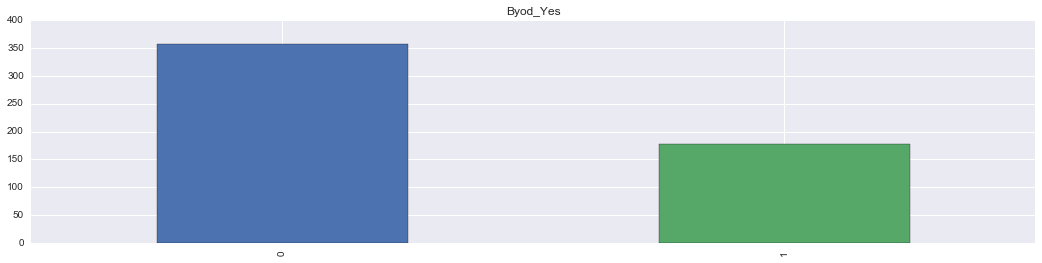

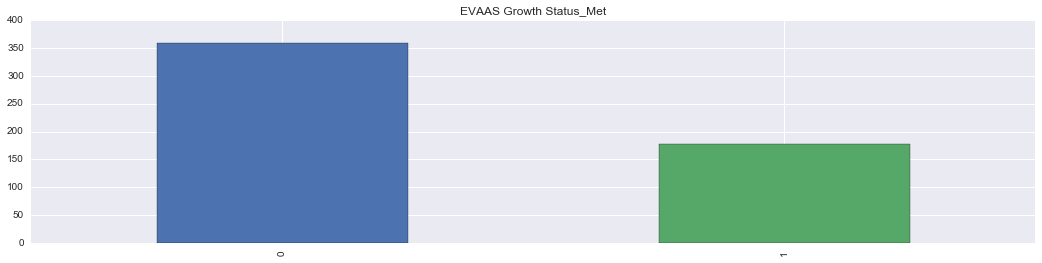

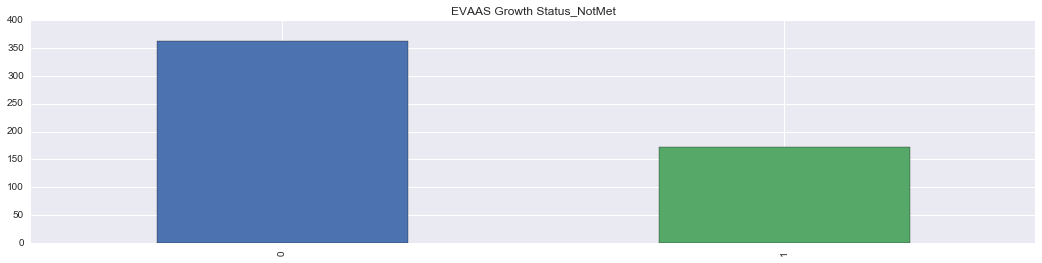

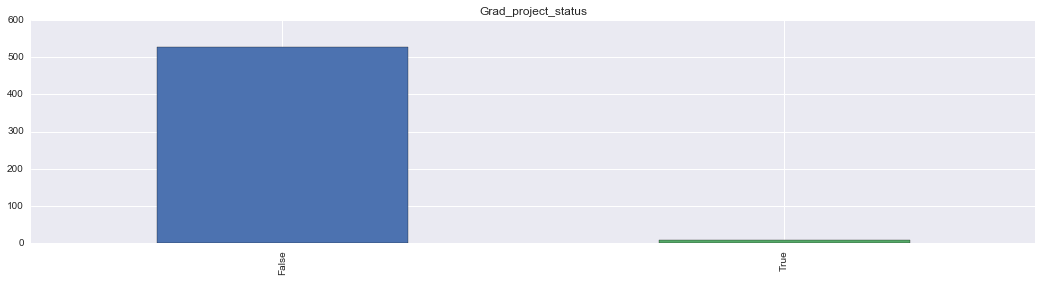

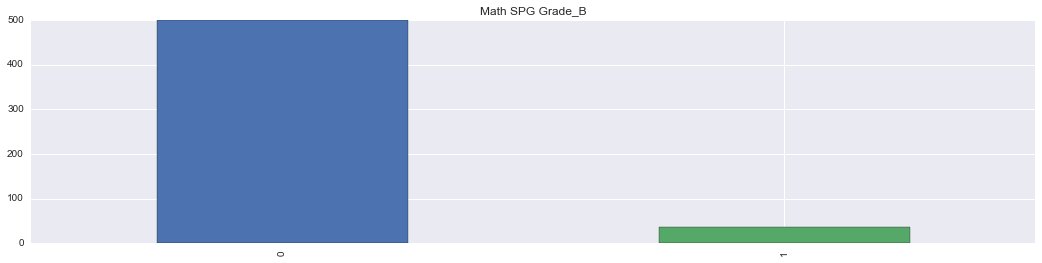

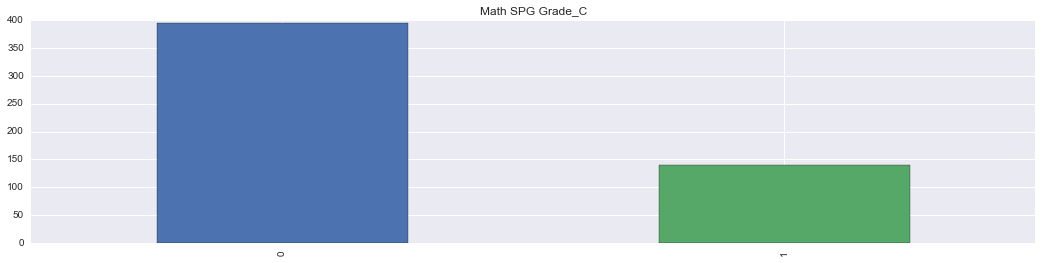

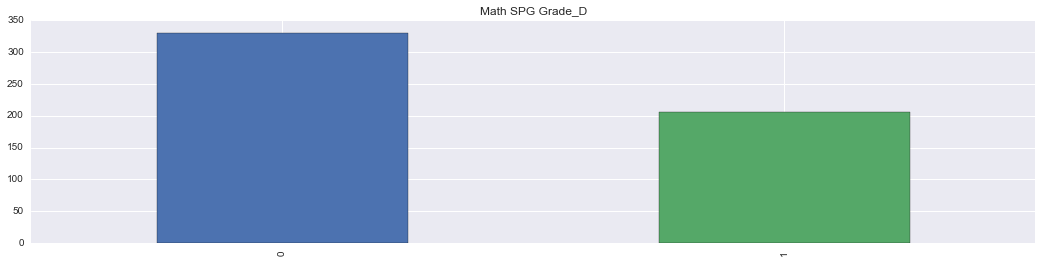

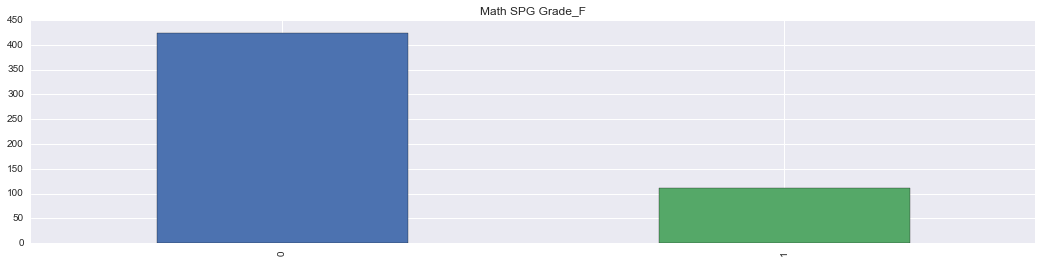

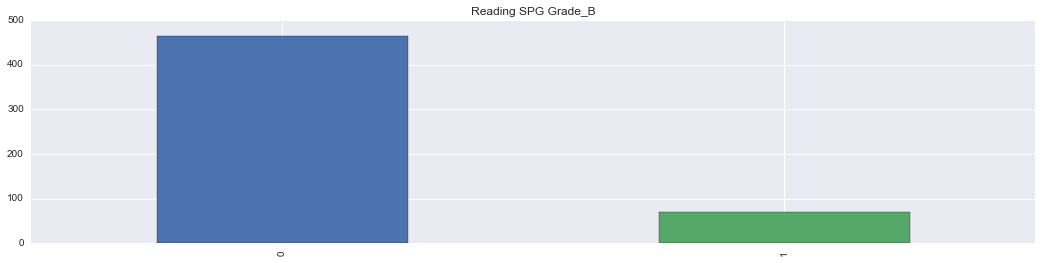

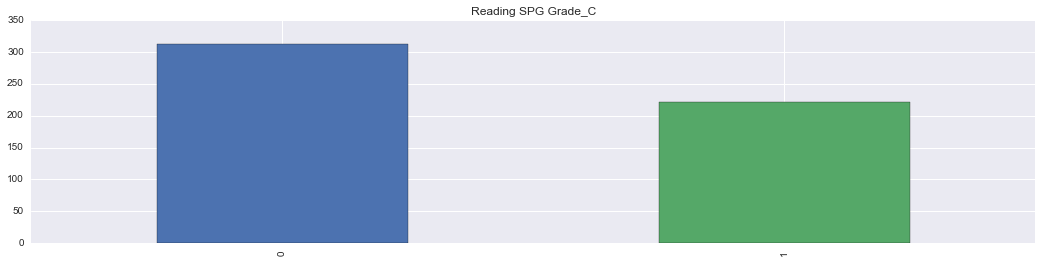

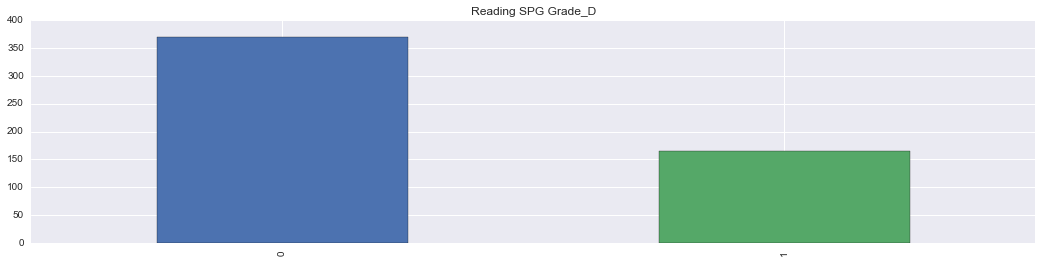

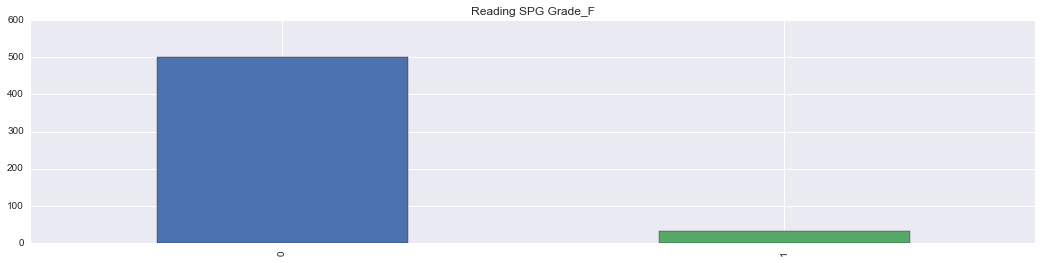

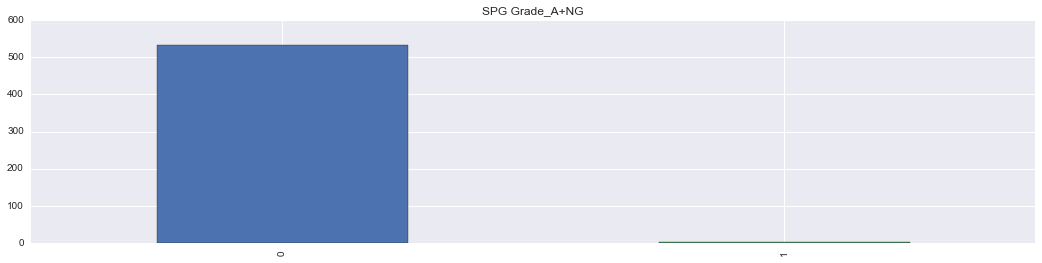

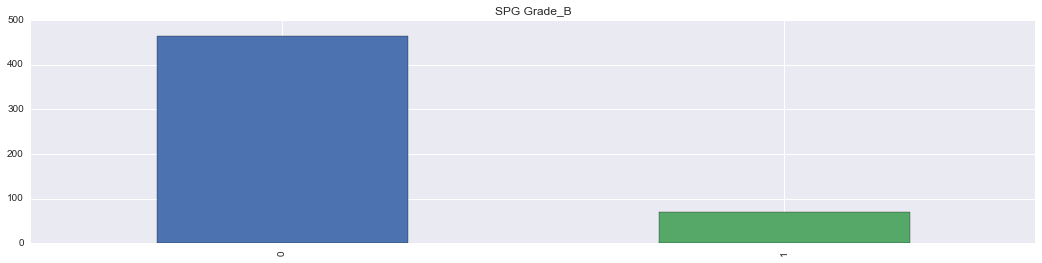

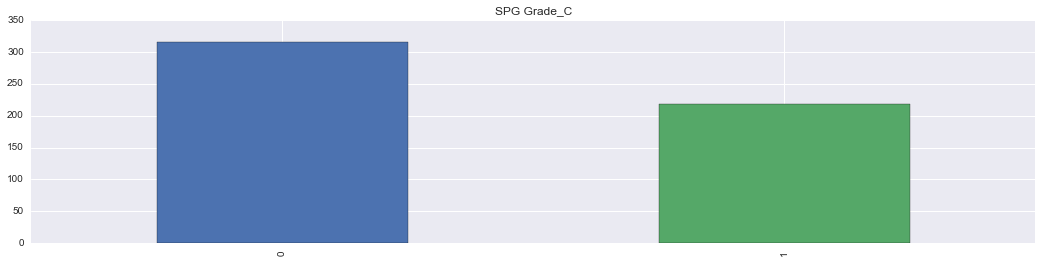

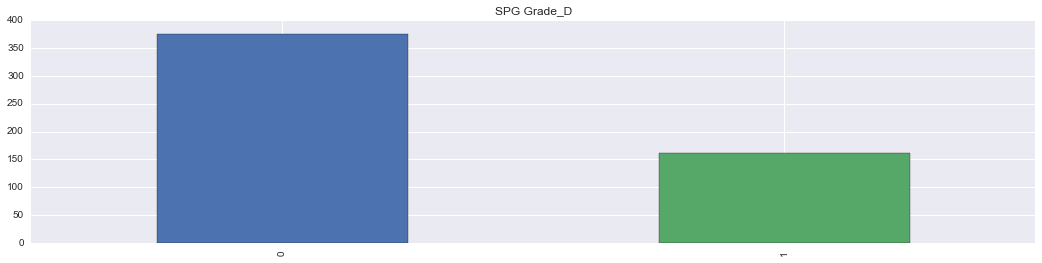

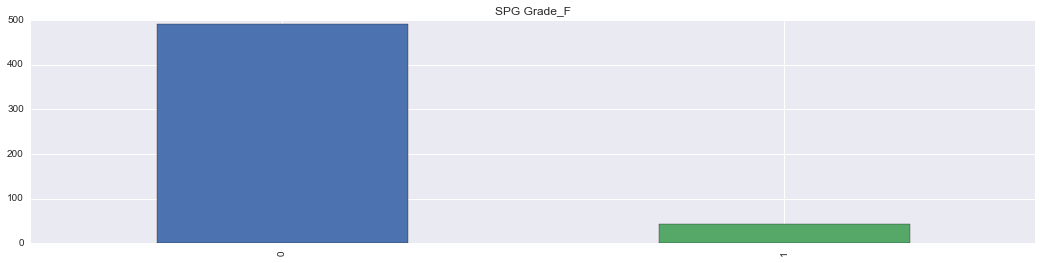

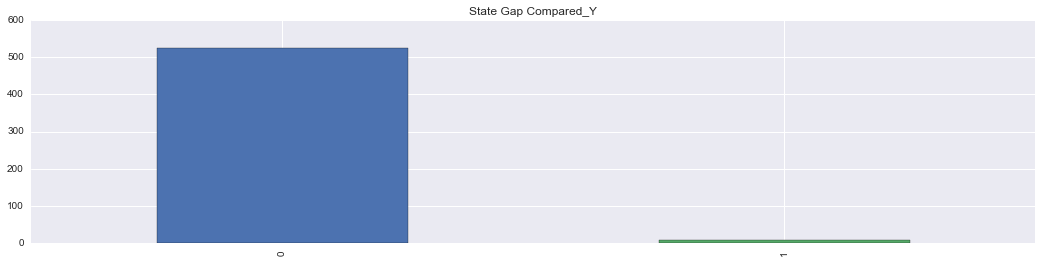

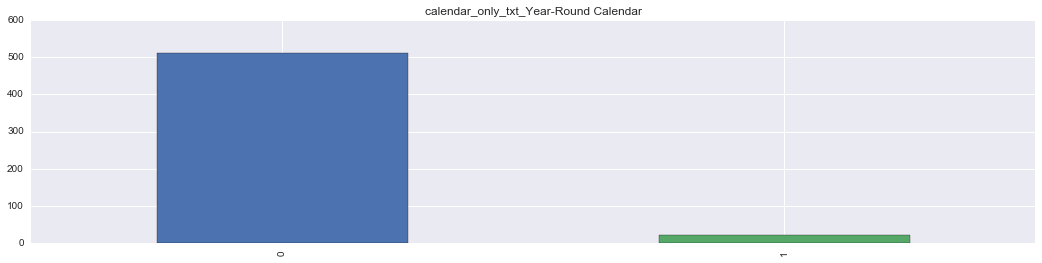

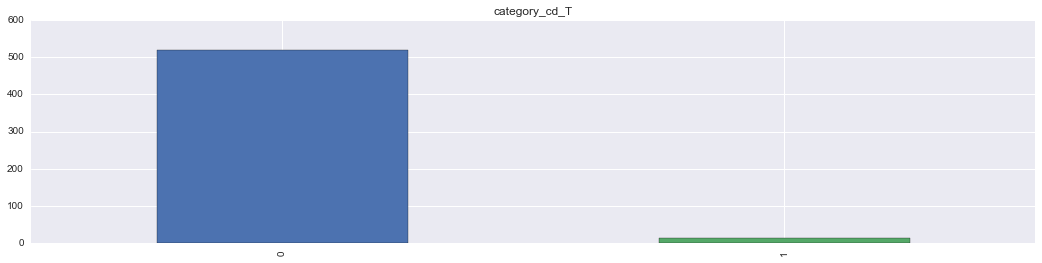

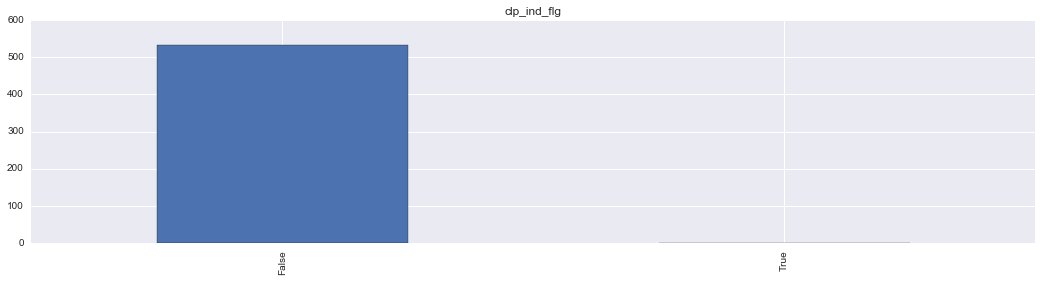

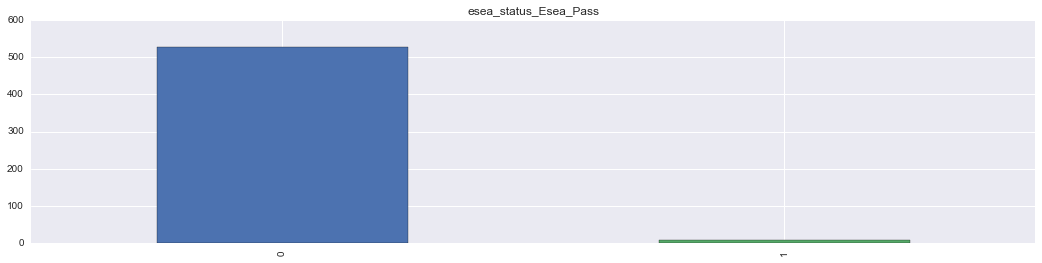

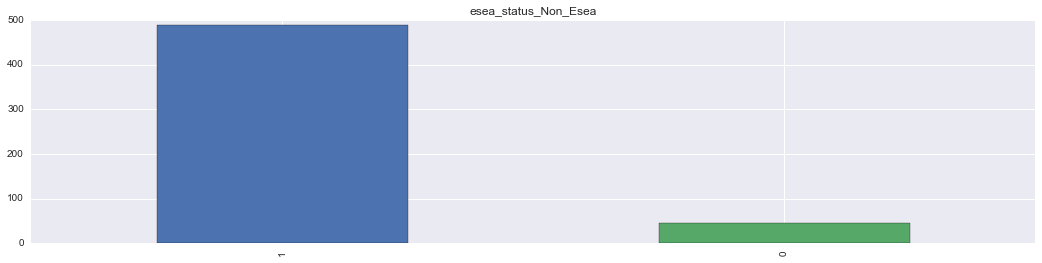

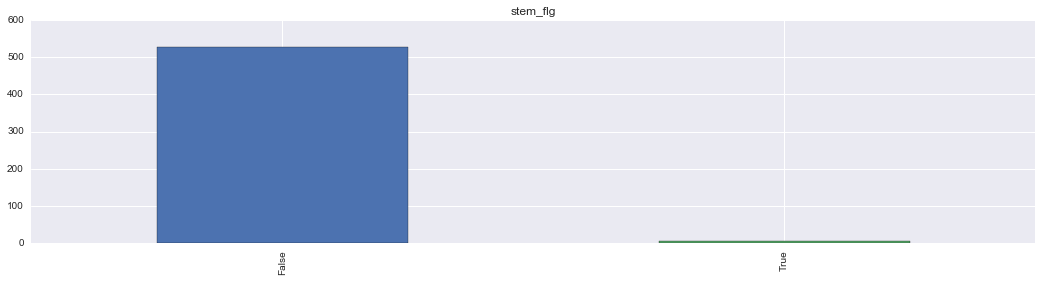

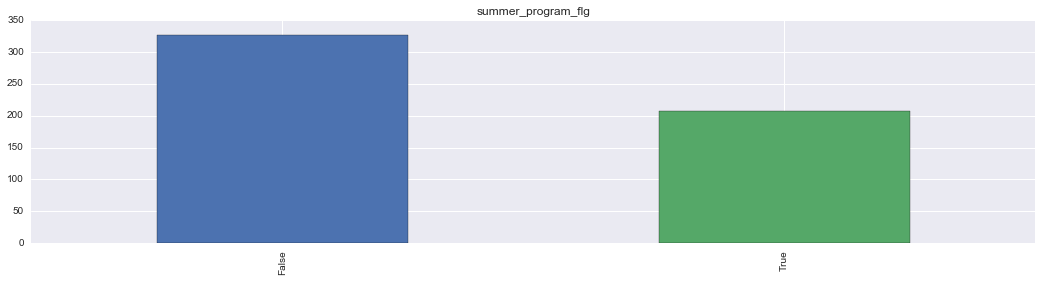

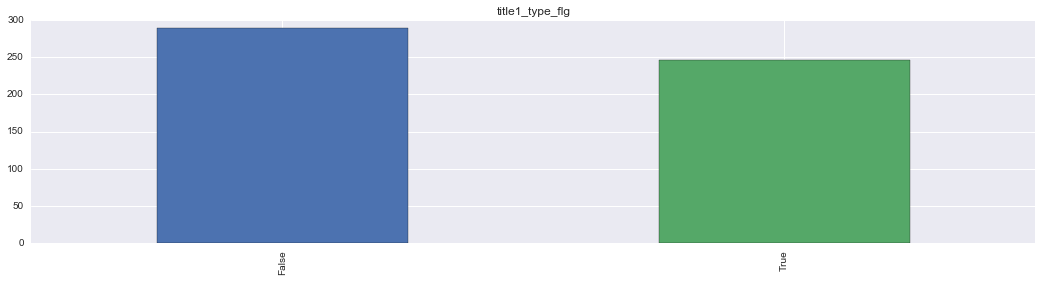

In [17]:
# Find all the categorical variables
schoolData_Bool = schoolData.loc[:, schoolData.dtypes == bool]
schoolData_Vars = schoolData.loc[:, schoolData.dtypes == object]
schoolData_Ohe_Vars = schoolData.select_dtypes(include='uint8')
cat_list_obj = list(pd.concat([schoolData_Vars, schoolData_Bool, schoolData_Ohe_Vars]))
cat_list_obj_len = len(cat_list_obj)
# Examine categorical variables of interest  
import matplotlib.pyplot as plt

print('Total categorical columns: ', cat_list_obj_len)

for i in range(0,len(cat_list_obj)):
    plt.figure(figsize = (18,4))
    ax = schoolData[cat_list_obj[i]].value_counts().plot(kind='bar')
    plt.title(cat_list_obj[i])
    plt.show()

In [45]:
import sklearn
import pandas as pd

print('Sklearn Version: ' + sklearn.__version__)
print('Pandas Version: ' + pd.__version__)

Sklearn Version: 0.19.1
Pandas Version: 0.22.0
